In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_customer = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Data Science/Case Study/Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Data Science/Case Study/Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Data Science/Case Study/Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/drive/MyDrive/PBI Kalbe Data Science/Case Study/Case Study - Transaction.csv', delimiter=';')

In [ ]:
df_customer.dropna(subset=['Marital Status'], inplace=True)
# Data cleansing for df_customer by replacing ',' with '.' for the 'Income' column
df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')
# Data cleansing for df_store by replacing ',' with '.'
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')
# Data cleansing for df_transaction by changing the Date format to datetime
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

# Group by 'TransactionID' and select the row with the maximum 'Date'
df_transaction = df_transaction.sort_values(by='Date', ascending=False) \
    .groupby('TransactionID', as_index=False).first()

In [ ]:
# Merge the DataFrames
df_merge = pd.merge(df_transaction, df_customer, on='CustomerID', how='inner')
df_merge = pd.merge(df_merge, df_product.drop(columns=('Price')), on='ProductID', how='inner')
df_merge = pd.merge(df_merge, df_store, on='StoreID', how='inner')

### **clustering**

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR10008,235,2022-05-21,P8,16000,2,32000,4,37,0,Married,5.35,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
1,TR39070,350,2022-06-23,P8,16000,2,32000,4,38,0,Single,7.95,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
2,TR8584,293,2022-09-14,P8,16000,3,48000,4,54,0,Married,10.40,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR69229,46,2022-05-07,P8,16000,2,32000,4,36,1,Married,8.31,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR88920,447,2022-01-16,P8,16000,1,16000,4,54,1,Married,20.37,Oat,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_merge.corr()
correlation_matrix

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016848,-0.013039,-0.027297,0.008386,-0.022445,-0.018030,0.004778,0.006296,-0.006894
Price,-0.016848,1.000000,-0.353870,0.440091,-0.031161,0.014174,0.011297,0.001985,-0.026628,0.018088
Qty,-0.013039,-0.353870,1.000000,0.621611,0.011983,-0.026400,-0.010760,-0.032228,-0.008123,0.006392
TotalAmount,-0.027297,0.440091,0.621611,1.000000,-0.012294,-0.015377,-0.009347,-0.027208,-0.031321,0.026888
StoreID,0.008386,-0.031161,0.011983,-0.012294,1.000000,-0.007778,-0.002103,0.003226,0.469529,-0.096025
Age,-0.022445,0.014174,-0.026400,-0.015377,-0.007778,1.000000,-0.026988,0.485602,0.007204,0.020950
Gender,-0.018030,0.011297,-0.010760,-0.009347,-0.002103,-0.026988,1.000000,-0.066849,-0.010182,-0.000047
Income,0.004778,0.001985,-0.032228,-0.027208,0.003226,0.485602,-0.066849,1.000000,0.019291,0.002871
Latitude,0.006296,-0.026628,-0.008123,-0.031321,0.469529,0.007204,-0.010182,0.019291,1.000000,-0.393545
Longitude,-0.006894,0.018088,0.006392,0.026888,-0.096025,0.020950,-0.000047,0.002871,-0.393545,1.000000


Based on the correlation matrix and considering the goal of clustering similar customers, we can either use Qty or TotalAmount as parameter since it's correlation value is similar. For this model, we use TotalAmount for the parameter.

In [ ]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID': 'count',
    'TotalAmount': 'sum'
}).reset_index()

In [ ]:
df_cluster.head()

,CustomerID,TransactionID,TotalAmount
0,1,17,623300
1,2,12,382300
2,3,15,446200
3,4,10,302500
4,5,7,268600


In [ ]:
data_cluster = df_cluster.drop(columns=['CustomerID'])
data_cluster_normalize = preprocessing.normalize(data_cluster)

In [ ]:
data_cluster_normalize

In [ ]:
K = range(2, 8)
fits = []
score = []

for k in K:
    model = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(data_cluster_normalize)
    fits.append(model)
    score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

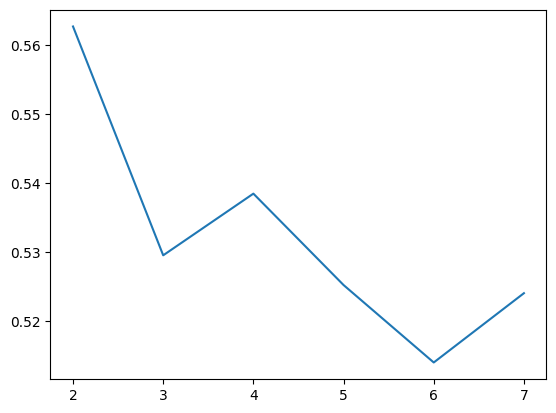

In [ ]:
#choose 4 cluster
sns.lineplot(x = K, y = score);

In [ ]:
fits[1]

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [ ]:
df_cluster['cluster_label'] = fits[1].labels_
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID': 'count',
    'TransactionID': 'mean',  # Remove the space here
    'TotalAmount': 'mean',
})

,CustomerID,TransactionID,TotalAmount
cluster_label,,,
0,167,10.982036,417692.215569
1,61,9.918033,229455.737705
2,216,11.226852,338010.185185


From the result above, it can be conclude that:
1. Customers in Cluster 0 have a relatively high number of transactions (TransactionID) and the highest average total spending (TotalAmount). This cluster represents customers who are frequent shoppers and spend a significant amount of money.

2. Customers in Cluster 1 have the lowest number of transactions (TransactionID)and the lowest  total spending (TotalAmount). These customers are somewhat less frequent shoppers and spend less on average.

3. Customers in Cluster 2 have the highest average number of transactions (TransactionID) and a substantial average total spending (TotalAmount), although it's lower than Cluster 0. This cluster represents customers who are both frequent shoppers and have a relatively high total spending.


